In [1]:
import platform
os = platform.system()
if os is 'Linux':
    !apt install chromium-browser
    !pip install websocket-client

In [2]:
import websocket
import json

class ChromeDevToolsProtocolError(Exception):
    def __init__(self, error):
        self.error = error
    
    def __repr__(self):
        return 'ChromeDevToolsProtocolError: ', json.dumps(self.error)

class ChromeDevToolsProtocol():
    def __init__(self, url):
        self.ws = websocket.create_connection(url, timeout=1)
        self.nonce = 0
        self.sessionId = None
        self.handlers = {}
        self.on('Target.attachedToTarget', self.attachedToTarget)
        self.on('Target.detachedFromTarget', self.detatchedFromTarget)
    
    def attachedToTarget(self, **params):
        self.sessionId = params['sessionId']
    
    def detatchedFromTarget(self, **params):
        self.sessionId = None
        
    def on(self, method, handler):
        self.handlers[method] = handler
        
    def send(self, method, **params):
        
        self.nonce += 1
        
        msg = dict(id=self.nonce, method=method, params=params)
        if self.sessionId is not None:
            msg['sessionId'] = self.sessionId
            
        self.ws.send(json.dumps(msg))
        
        while True:
            raw = self.ws.recv()
            reply = json.loads(raw)

            if 'method' in reply:
                self._handleEvent(reply['method'], **reply['params'])
            else:  
                assert reply['id'] == self.nonce
                if 'error' in reply:
                    raise ChromeDevToolsProtocolError(reply['error'])
                else:
                    return reply['result']
    
    
    def pump(self):
        try:
            raw = self.ws.recv()
            reply = json.loads(raw)
            
            if 'method' in reply:
                self._handleEvent(reply['method'], **reply['params'])
        except websocket.WebSocketTimeoutException:
            pass
    
    def _handleEvent(self, method, **params):
        print('event:', method, params)
        if method in self.handlers:
            self.handlers[method](**params)
    
    def close(self):
        self.ws.close()

In [30]:
from IPython.display import display, clear_output, Image
import base64
import subprocess
chrome_args = "--remote-debugging-port=9222 --headless --no-sandbox --enable-surface-synchronization --run-all-compositor-stages-before-draw --disable-threaded-animation --disable-threaded-scrolling --disable-checker-imaging --disable-gpu"
class GameDriver():
    def __init__(self):
        def windows(self):
            self.chrome = subprocess.Popen(".\\chrome-win\\chrome chromium-browser "+chrome_args, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            output = ""
            while "ws" not in str(output):
                output = self.chrome.stderr.readline()
            assert("ws" in str(output))
            return str(output[str(output).index("ws")-2:-2])[2:]

        def linux(self):
            !echo > nohup.out
            self.chrome = !bash -c "nohup "+ chrome_args + " &"
            !sleep 1
            !cat nohup.out
            lines = !grep ws nohup.out | cut -f4 -d' '
            return lines[0]

        if os == 'Windows':
            url = windows(self)
        elif os == 'Linux':
            url = linux(self)
        print("hosting at: " + url)
        self.cdp = ChromeDevToolsProtocol(url)
    
    def close(self):
        if os == "Windows":
            self.chrome.kill()
            return self.chrome.wait()
        
    def navigate(self, address):
#         if 'itch' in address:
#             iframe = self.cdp.find_elements_by_tag_name('iframe')[0]
#             iframe_url = "https:" + iframe.get_attribute("src")
        nav_output = self.cdp.send('Page.navigate', url=address)
        self.inject_event_script()
        return nav_output

    def inject_event_script(self):
        collection_script = '''(() => {
        let events = [];
        const inputs = (key, e) => [key, key.startsWith('mouse') ? [e.clientX, e.clientY, e.button] : String.fromCharCode(e.keyCode)]
        ['mousedown', 'mousemove', 'mouseup', 'keyup', 'keydown'].forEach(k => window.addEventListener(k, e => events.push({[+new Date()]: inputs(k,e)}),true));
        window._getRecentEvents = () => events.splice(0, events.length);
        })();'''
#         self.cdp.execute_script(collection_script)
        self.cdp.send("Runtime.evaluate", expression=collection_script)
        
    def get_browser_version(self):
        return self.cdp.send('Browser.getVersion')
    
    def init_ip(self):
        targetId = self.cdp.send('Target.createTarget', url='http://ipchicken.com', enableBeginFrameControl=True)['targetId']
        sessionId = self.cdp.send('Target.attachToTarget', targetId=targetId,flatten=True)['sessionId']
    
    def pause(self):
        return self.cdp.send('Emulation.setVirtualTimePolicy', policy='pause')

    def step(self, dur = 30):
        events = []
        for i in range(dur):
            self.cdp.send('HeadlessExperimental.beginFrame')
            batch = self.cdp.send("Runtime.evaluate", expression='return window._getRecentEvents();')
            events.extend(batch)
        return events
    
    def press_key(self, key):
        def text(letter):
            self.cdp.send("Input.dispatchKeyEvent", {"type":"keyDown", "windowsVirtualKeyCode":ord(letter), "nativeVirtualKeyCode":ord(letter), "key":letter})
            self.cdp.send("Input.dispatchKeyEvent", {"type":"char", "text": letter, "key": letter})
            self.cdp.send("Input.dispatchKeyEvent", {"type":"keyUp", "windowsVirtualKeyCode":ord(letter), "nativeVirtualKeyCode":ord(letter), "key": letter})

#         def space():
#             self.cdp.send("Input.dispatchKeyEvent", {"type":"keyDown", "windowsVirtualKeyCode":32, "nativeVirtualKeyCode":32})
#             self.cdp.send("Input.dispatchKeyEvent", {"type":"char", "text": " " })
#             self.cdp.send("Input.dispatchKeyEvent", {"type":"keyUp", "windowsVirtualKeyCode":32, "nativeVirtualKeyCode":32})

        def arrow(dir):
            dirs = ["Left", "Up", "Right", "Down"]
            self.cdp.send("Input.dispatchKeyEvent", {"type":"keyDown", "windowsVirtualKeyCode":37 + dirs.index(dir), "nativeVirtualKeyCode":37 + dirs.index(dir), "key": "Arrow" + dir})
            self.cdp.send("Input.dispatchKeyEvent", {"type":"keyUp", "windowsVirtualKeyCode":37 + dirs.index(dir), "nativeVirtualKeyCode":37 + dirs.index(dir), "key": "Arrow" + dir})
            
        success = False
        if(key.isalnum() or key is " "):
            text(key)
            success = True
        return success
    
    def press_mouse(self, pos, button, hold = False):
        self.cdp.send('Input.dispatchMouseEvent', type='mousePressed', x=pos.x, y=pos.y, button='left')
        
    def get_screenshot(self):
        res = self.cdp.send('HeadlessExperimental.beginFrame', screenshot={'format':'jpeg'})#, noDisplayUpdates=True)
        print(res)
        if 'screenshotData' in res:
            clear_output()
            display(Image(base64.b64decode(res['screenshotData'])))
        return res

In [ ]:
!ps

In [ ]:
!kill 1734

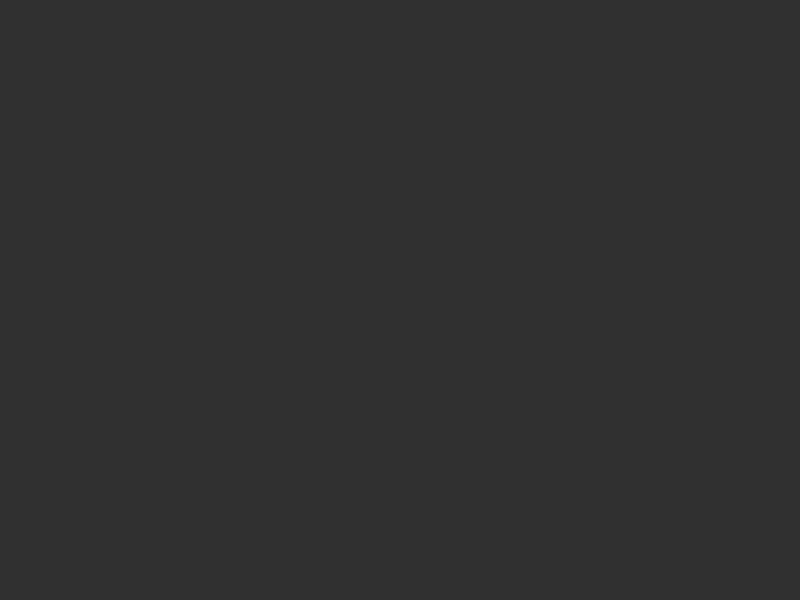

1
closed


{'hasDamage': True,
 'screenshotData': '/9j/4AAQSkZJRgABAQAAAQABAAD/4gIoSUNDX1BST0ZJTEUAAQEAAAIYAAAAAAIQAABtbnRyUkdCIFhZWiAAAAAAAAAAAAAAAABhY3NwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAA9tYAAQAAAADTLQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAlkZXNjAAAA8AAAAHRyWFlaAAABZAAAABRnWFlaAAABeAAAABRiWFlaAAABjAAAABRyVFJDAAABoAAAAChnVFJDAAABoAAAAChiVFJDAAABoAAAACh3dHB0AAAByAAAABRjcHJ0AAAB3AAAADxtbHVjAAAAAAAAAAEAAAAMZW5VUwAAAFgAAAAcAHMAUgBHAEIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAFhZWiAAAAAAAABvogAAOPUAAAOQWFlaIAAAAAAAAGKZAAC3hQAAGNpYWVogAAAAAAAAJKAAAA+EAAC2z3BhcmEAAAAAAAQAAAACZmYAAPKnAAANWQAAE9AAAApbAAAAAAAAAABYWVogAAAAAAAA9tYAAQAAAADTLW1sdWMAAAAAAAAAAQAAAAxlblVTAAAAIAAAABwARwBvAG8AZwBsAGUAIABJAG4AYwAuACAAMgAwADEANv/bAEMABgQFBgUEBgYFBgcHBggKEAoKCQkKFA4PDBAXFBgYFxQWFhodJR8aGyMcFhYgLCAjJicpKikZHy0wLSgwJSgpKP/bAEMBBwcHCggKEwoKEygaFhooKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKP/AABEIAlgD

In [31]:
driver = GameDriver()
driver.init_ip()
try:
    driver.navigate("https://v6p9d9t4.ssl.hwcdn.net/html/1379043/index.html")
    driver.pause()
    print("navigated properly")
    image = driver.get_screenshot()
except Exception as e:
    print("failed to navigate with exception: ")
    print(e)
finally:
    print(driver.close())
    print("closed")
image